In [1]:
import torch
from torch import nn

import numpy as np
from PIL import Image
%matplotlib inline


# Model

In [2]:
from Models import CustomHasher, SmallHasher, ResnetHasher
SmallHasher().visualize()
model = SmallHasher()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
              ReLU-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
       HasherBlock-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 20, 16, 16]           2,900
         MaxPool2d-7           [-1, 20, 16, 16]               0
              ReLU-8           [-1, 20, 16, 16]               0
       BatchNorm2d-9           [-1, 20, 16, 16]              40
      HasherBlock-10           [-1, 20, 16, 16]               0
           Conv2d-11             [-1, 28, 8, 8]           5,068
        MaxPool2d-12             [-1, 28, 8, 8]               0
             ReLU-13             [-1, 28, 8, 8]               0
      BatchNorm2d-14             [-1, 2

# Load Training Data

In [3]:
import glob
class TripletDataset(torch.utils.data.Dataset):    
    def __init__(self, directory, transforms):
        self.transforms = transforms
        
        self.file_list = glob.glob(f'{directory}/*.png')
        self.file_list.sort()
        self.num_items_available = len(self.file_list)

        # from imageaug
        self._tt = ToRGBTensor()
        
        print(f'Found {len(self.file_list)} images.')

    def __len__(self):
        return self.num_items_available
    
    def __getitem__(self, index):
        anchor   = Image.open(self.file_list[index])
        positive = self.transforms(anchor)

        return (self._tt(anchor), self._tt(positive))

### Image Augmentation/Transforms

In [4]:
from torchvision.transforms import Compose
from imageaug import *

transforms = Compose([
    ApplyOne(Noise(), Greyscale()),
    ApplyOne(RandomRotate(range(0, 360, 30)), RandomFillCrop(1))
]) 

In [5]:
dataset = TripletDataset('TrainDataset', transforms)
validationset = TripletDataset('ValidDataset', transforms)

Found 576150 images.
Found 192051 images.


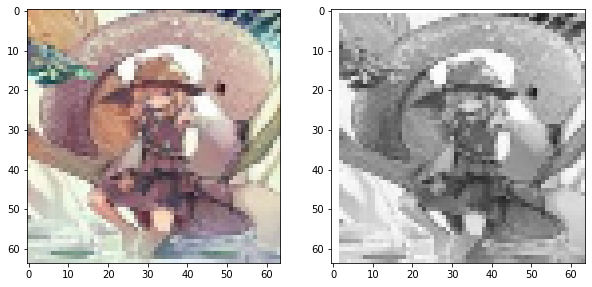

In [6]:
from vistools import show_imgpair

show_imgpair(dataset[3])

In [7]:
n = 64

# Dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, num_workers=8, batch_size=n, shuffle=True, drop_last=True)
valid_loader = DataLoader(validationset, num_workers=4, batch_size=n, shuffle=True, drop_last=True)

# Model
model = SmallHasher()

# Loss
margin = 2
p = 2

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=.01)

## Triplet Loss:
$$L(\displaystyle A,\displaystyle P,\displaystyle N,\displaystyle \alpha) = max\Big( d(f(\displaystyle A), f(\displaystyle N)) − d(f(\displaystyle A), f(\displaystyle P)) + \displaystyle \alpha, 0 \Big)$$

Where:
* ${\displaystyle A}$ is an anchor input, 
* ${\displaystyle P}$ is a positive input of the same class as ${\displaystyle A}$, 
* ${\displaystyle N}$ is a negative input of a different class from ${\displaystyle A}$, 
* ${\displaystyle \alpha }$  is a margin between positive and negative pairs, 
* ${\displaystyle f}$ is an embedding onto a metric space (the model we're training), and 
* $d$ is a distance function on that space. (In this case L1 or L2 norm, Manhattan and Euclidean distance respectively).

Taken from FaceNet paper
https://arxiv.org/abs/1503.03832

## N-Tuple Loss
Triplet loss as described above accomplishes unsupervised learning of embeddings. This is all well and good, but what if we wanted to up the ante a bit? Triplet loss pushes the embeddings of two images farther apart. But what if we wanted to push even more embeddings apart, probably more intelligently, in a single step? Behold my monstrosity, n-tuple loss.

Let $f$ be an embedding from the input space onto metric space. In this case, $f$ represents our model.

Let $d$ be a distance function on that metric space.

Let $\alpha$ be the desired distance margin between embeddings which do not have the same class.

Let $A$ be a tuple of $n$ anchor inputs from separate classes, and $P$ be a tuple of $n$ corresponding positive matches from each class, and let that class be distinct. That is to say, $A_i$ and $P_i$ are of the same class, but the classes of $A_i$ and $A_j$, and of $A_i$ and $P_j$, are different for all $i,j$ from 0 to n-1 where $i \neq j$.

Finally, 

$$L(\displaystyle A,\displaystyle P,\displaystyle \alpha) = \sum_{i=0}^{n-1} \sum_{j=i+1}^{n-1} \Big\lbrack d(f(A_j), f(P_j)) - d(f(A_i),f(A_j)) + \alpha \Big\rbrack_{+}.$$

## But, why?

The main difference is that training the model in this way allows for more information to be digested from each batch. Triplet loss is effective, but it is wasteful in the sense that there's a lot of computation that could be done to spread the embeddings that isn't being done.

Suppose that $n$ images are run through the model. Half of the images become anchor images, half become negative images, and positive images are generated through data augmentation from the anchors. For normal triplet loss, this is a batch of $\frac{n}{2}$ comparisons. Although at the end of the forward pass we have embeddings in memory to compute the loss for an anchor/positive pair and an anchor, and the results would be just as meaningful as the one that triplet loss compares it to, we do not.

However, if we run the same $n$ images through the model and do the above, we can do a lot more cross comparison. We let anchor images also act as negatives, generate the positives through data augmentation, and make every comparison possible. This ends up being ${n\choose 2} = \frac{n^2 - n}{2}$ comparisons.

The number of comparisons that can be done grows quadratically by the above rate. This results in many more comparisons than normal triplet loss, hopefully leading to a higher quality of gradient updates and more accurate convergence.

Suppose $n = 64$, which seems like a reasonable sample size. With triplet loss, 32 comparisons would be done. This scheme does 2,016 of them, with no additional forward passes required. As the sample size increases, which tends to happen when people are trying to train models faster and faster, the difference gets even more pronounced. A sample size of 128 yeilds 8,128 comparisons compared to triplet loss's 64.

It should be noted however that because the magnitude of the weight update is determined linearly by the size of the batch, and the effort required to cross compare a large number of combinations of samples may become too expensive to justify for the increase in the quality of the gradient update, particularly at the start of training the model.

There are many factors that go into optimization at the end. 

## N-Tuple Loss Implementation

In [8]:
# Generate all possible combinations of (i, j) for n given by the above scheme
from itertools import combinations
ij_pairs = list(combinations(range(0, n), r=2))
num_combinations = len(ij_pairs)
print(num_combinations)

2016


In [9]:
from torch.nn.functional import pairwise_distance

def ntuplet_loss(anchor_embeddings, positive_embeddings, margin=2, p=2):
    # Embeddings are stacked tensors of batchnum many embeddings. These stacks have shape (n, embedding_size).

    # Calculate distances between anchors and their respective positive matches.
    ap_distances = pairwise_distance(anchor_embeddings, positive_embeddings, keepdim=True, p=p)


    losses = []
    for ij_pair in ij_pairs:
        i, j = ij_pair
        
        combination_ij_distance = torch.dist(anchor_embeddings[i], anchor_embeddings[j], p=p)

        # Minimizing this means maximizing combination_ij_distances and minimizing ap_distances.
        dist = ap_distances[j] - combination_ij_distance  + margin
        
        single_loss = torch.max(dist, torch.zeros_like(dist, requires_grad=True))
        losses.append(single_loss)
        
    return sum(losses) / num_combinations

In [10]:
# Triplet Loss
triplet_loss = torch.nn.TripletMarginLoss(margin=margin, p=p)

# Training Loop

In [11]:
from time import time

def forward_and_loss(batch, epoch):
        # Train the first two batches with triplet loss, and ntuplet loss for the rest.
        if epoch <= 2:
                # Segment batch
                anchor_images,   negative_images = torch.split(batch[0], batch[0].shape[0]//2, dim=0)
                positive_images, unused          = torch.split(batch[1], batch[1].shape[0]//2, dim=0)

                # Forward
                anchor_embeddings   = model.forward(anchor_images)
                positive_embeddings = model.forward(positive_images)
                negative_embeddings = model.forward(negative_images)

                # Backward
                loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
                
        else:
                # Forward
                anchor_embeddings   = model.forward(batch[0])
                positive_embeddings = model.forward(batch[1])
        
                # Backward
                loss = ntuplet_loss(anchor_embeddings, positive_embeddings, margin=margin, p=p)

        return loss

# Returns loss
def train_batch(model, batch, batchnum):
        batch_start_time = time()

        # Enable Training
        model.train()
        model.zero_grad()

        # Forward and calculate loss
        loss = forward_and_loss(batch, epoch)

        # Apply grad update
        loss.backward()
        opt.step()

        # Print
        batch_end_time = time()
        loss_num = loss.item()
        if print_batches:
            print_batch('train', loss_num, dataset, batch_start_time, batch_end_time)
        
        return loss_num


# Returns loss
def valid_batch(model, vbatch, batch_num):
        batch_start_time = time()

        # Disable Training
        with torch.no_grad():
                model.eval()

                loss = forward_and_loss(batch, epoch)

                # Print
                batch_end_time = time()
                loss_num = loss.item()
                if print_batches:
                    print_batch('valid', loss_num, validationset, batch_start_time, batch_end_time)
        
        return loss_num

In [12]:
print_batches = True
def print_batch(tv, loss_num, dataset, batch_start_time, batch_end_time):
        batch_time = round(batch_end_time-batch_start_time, 2)
        num_batches = (dataset.num_items_available // n) - 1
        est_epoch_time_seconds = batch_time*num_batches
        est_epoch_time_minutes = round(est_epoch_time_seconds / 60, 2)
        print(f'\rCompleted {tv} batch: {str(batch_num).rjust(4, " ")} of {num_batches} | \
Loss: {"{:6.4f}".format(loss_num)} | \
Time: {str(batch_time).rjust(6, " ")} (est. {"{:4.1f}".format(est_epoch_time_minutes)} min for epoch)', end='')

In [13]:
import copy
best_weights = None
best_loss = np.inf


# Train for at most 1000 epochs. There's no way it will take that long.
for epoch in range(1, 50):
    
    # Training Batches
    batch_num = 0
    epoch_start_time = time()
    for batch_num, batch in enumerate(train_loader):
        train_batch(model, batch, batch_num)
    
    # So carriage return prints train/valid on different lines
    if print_batches:
        print()

    # Validation batches
    batch_num = 0
    batch_valid_losses = []
    for batch_num, vbatch in enumerate(valid_loader):
        loss_num = valid_batch(model, vbatch, batch_num)
        batch_valid_losses.append(loss_num)
    valid_loss = sum(batch_valid_losses) / len(batch_valid_losses)
    
    # Print epoch results
    epoch_end_time = time()
    epoch_time_minutes = round((epoch_end_time - epoch_start_time) / 60, 2)
    print(f"""\n\
╔══════════════════════════════════════════════════════════════════╗\n║ \
End of Epoch: {str(epoch).rjust(3, " ")} | \
Validation Loss: {"{:7.4f}".format(valid_loss)} | \
Time: {str(epoch_time_minutes).rjust(6, " ")} min. ║\n\
╚══════════════════════════════════════════════════════════════════╝\n""")

    # Save best weigths, early stopping
    if best_loss < valid_loss and epoch >= 1:
        # Cannot on first pass b/c best_loss is infinity. Then it 
        # proceeds to the else. This handles early stopping.
        break
    else:
        # The model has not overfit. Save the weights and keep going until it does.
        best_weights = copy.deepcopy(model.state_dict()), 
        best_loss = valid_loss
model.load_state_dict(best_weights)

Completed train batch: 9001 of 9001 | Loss: 0.6288 | Time:   0.07 (est. 10.5 min for epoch)
Completed valid batch: 2999 of 2999 | Loss: 0.5351 | Time:   0.03 (est.  1.5 min for epoch)
╔══════════════════════════════════════════════════════════════════╗
║ End of Epoch:   1 | Validation Loss:  0.5351 | Time:  18.14 min. ║
╚══════════════════════════════════════════════════════════════════╝

Completed train batch: 9001 of 9001 | Loss: 0.2484 | Time:   0.08 (est. 12.0 min for epoch)
Completed valid batch: 2999 of 2999 | Loss: 0.3750 | Time:   0.03 (est.  1.5 min for epoch)
╔══════════════════════════════════════════════════════════════════╗
║ End of Epoch:   2 | Validation Loss:  0.3750 | Time:  15.68 min. ║
╚══════════════════════════════════════════════════════════════════╝

Completed train batch: 9001 of 9001 | Loss: 0.1891 | Time:   0.45 (est. 67.5 min for epoch)
Completed valid batch: 2999 of 2999 | Loss: 0.2120 | Time:   0.12 (est.  6.0 min for epoch)
╔═══════════════════════════════

# Export Model

In [14]:
export_model = True
model_path = 'Models/model%s.zip'


def next_path(path_pattern):
    i = 1
    while os.path.exists(path_pattern % i):
        i += 1
    return path_pattern % i

if export_model:
    fname = next_path(model_path)
    torch.save(model, fname)
    print(f'Saved model as: {fname}')

Saved model as: Models/model4.zip


# Load Model

In [13]:
model_path = "Models/model2.zip"
model = torch.load(model_path)

# Test Model

In [14]:
tt = ToRGBTensor()
def load_img(fname):
    return tt(Image.open(fname)).unsqueeze(0)
def compare_vectors(v1, v2):
    vec1, vec2 = v1[0], v2[0] # b/c second term is the file name
    return np.linalg.norm(vec1-vec2)

In [15]:
from tqdm import tqdm
import matplotlib.pyplot as plt

embeddings = []

# Turn off gradients
with torch.no_grad():
    model.eval()

    # Load all the validation data and hash it
    for fname in tqdm(validationset.file_list):
        embedding = model.forward(load_img(fname)).numpy()
        embeddings.append((embedding, fname))

100%|██████████| 192051/192051 [09:26<00:00, 338.72it/s]


In [16]:
compare_vectors(embeddings[0], embeddings[1])

4.593522

In [17]:
def show_matches(matches, axes=True):
    fname_list = [tup[1][1] for tup in matches]
    imgs = [Image.open(fname) for fname in fname_list]

    axs = plt.subplots(1, len(imgs), figsize=(10, 5))[1]
    axs = np.ravel(axs)

    for i in range(len(imgs)):
        axs[i].imshow(imgs[i])
        if not axes:
            axs[i].set_axis_off()
    plt.show()

In [18]:
print(len(embeddings))
print(np.log2(len(embeddings)))

192051
17.551129950366633


In [23]:
# Construct a vantage point tree for efficient nearest neighbor lookup
from vptree import VPTree
vpt = VPTree(embeddings, compare_vectors)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
plt.imshow(Image.open('VP_Test_Img.png'));
plt.show()

show_matches(vpt.get_n_nearest_neighbors(embeddings[4], 5))

In [25]:
# Construct a vantage point tree for efficient nearest neighbor lookup
from sys import setrecursionlimit
setrecursionlimit(1500)